In [ ]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from keras.utils.np_utils import to_categorical 
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import pickle

In [ ]:
df_train = pd.read_csv('51900789-Le Huyen Duc- 51900811- Nguyen Trung Kien - So 20 - train.csv')
print(df_train.shape)

(42000, 785)


In [ ]:
df_train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
df_train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [ ]:
y = df_train["label"]
X = df_train.values[:,1:]/255.0

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1)

KNN

In [ ]:
model_KNN = KNeighborsClassifier(n_neighbors=3)
model_KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred_KNN = model_KNN.predict(X_val)

In [ ]:
print("CategoricalKNN:\n")
print(classification_report(y_val,y_pred_KNN))
score_KNN = model_KNN.score(X_val, y_val)
print(score_KNN)

CategoricalKNN:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       853
           1       0.96      1.00      0.98       940
           2       0.98      0.96      0.97       835
           3       0.96      0.96      0.96       873
           4       0.98      0.97      0.98       829
           5       0.96      0.96      0.96       731
           6       0.98      0.99      0.98       800
           7       0.95      0.97      0.96       850
           8       0.99      0.92      0.95       846
           9       0.95      0.96      0.95       843

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400

0.9675


CNN

In [ ]:
X = X.reshape(-1,28,28,1)

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y, num_classes = 10)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1)

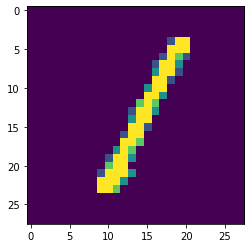

In [ ]:
g = plt.imshow(X_train[0][:,:,0])

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5), 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation = "softmax"))

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
epochs = 1 
batch_size = 86

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  
datagen.fit(X_train)

In [ ]:
model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                      epochs = epochs, validation_data = (X_val,y_val),
                      verbose = 2,
                      steps_per_epoch=X_train.shape[0] // batch_size, 
                      callbacks=[learning_rate_reduction])

390/390 - 78s - loss: 0.6330 - accuracy: 0.7937 - val_loss: 0.0842 - val_accuracy: 0.9745 - lr: 0.0010 - 78s/epoch - 199ms/step


In [ ]:
loss, accuracy = model.evaluate(X_val,y_val)
print("Accuracy: " + str(accuracy))
print("Loss: " + str(loss))

263/263 [==============================] - 4s 17ms/step - loss: 0.0842 - accuracy: 0.9745
Accuracy: 0.9745237827301025
Loss: 0.08417845517396927


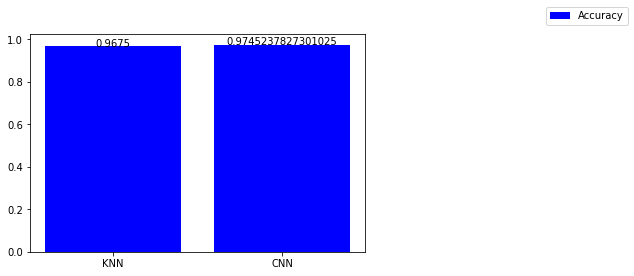

In [ ]:
#Ve bieu do
lModel = ['KNN','CNN']
lAcc = [score_KNN,accuracy]
fig, ax1 = plt.subplots(1,1)
ax1.bar(lModel,lAcc,color = 'blue',label = 'Accuracy')
ax1.legend(bbox_to_anchor =(1.8, 1.15))
for i in range(len(lModel)):
  ax1.text(lModel[i],lAcc[i],lAcc[i], ha = 'center')
plt.show()

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
df_test = pd.read_csv('51900789-Le Huyen Duc- 51900811- Nguyen Trung Kien - So 20 - test.csv')
print(df_test.shape)

(28000, 784)


In [ ]:
df_test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [ ]:
df_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
test = df_test.values/255.0

In [ ]:
test = test.reshape(-1,28,28,1)

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = loaded_model.predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

875/875 [==============================] - 19s 21ms/step


In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_test_label.csv",index=False)